# Linear Regression Analysis
---
**Research question**: "How many friends does a person have based on how much time they spend alone, post online, and whether they go outside and attend social events?"

I want to estimate how many friends a person may have based on time spent alone, how often they post online, and whether they attend social events when going outside (interaction).

$y = Friend\ Circle\ Size$

$\beta_0 = Intercept$

$\beta_1 = Time\ spent\ alone$

$\beta_2 = Post\ frequency$

$\beta_3 = Going\ outside$

$\beta_4 = Social\ event\ attendance$

$$y = \beta_0 + \beta_1x + \beta_2z + \beta_2*\beta_3$$

**NOTE:**
- Each survey item scale may be normally distributed, but when combined may form a non-normally distributed dataset.
    - We care about the error term being normally distributed ($\epsilon \sim N(0, \sigma^2))$.
    - We can standardize the survey scales to be proportions: $\frac{x}{max(x)}$

In [118]:
# Import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.formula.api import ols
from enum import Enum
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import bootstrap
import seaborn as sns

In [119]:
# Receive dataframe from Preprocessing
%store -r pre_df

# Converge personality into one column and remove the other columns.
# 1 = extrovert; 0 = introvert
pre_df["Personality"] = pre_df["Personality_Extrovert"]
pre_df = pre_df.drop(["Personality_Extrovert", "Personality_Introvert"], axis="columns")

# Save predictors array for re-use
predictors = ["Time_spent_Alone", "Post_frequency", "Going_outside", "Social_event_attendance"]

# Apply transformation to each variable
def transform(dataframe):
    for column in predictors:
        # Get proportion of responses.
        dataframe[column] = dataframe[column] / max(pre_df[column])

        # Apply log transform
        # dataframe[column] = np.where(dataframe[column] > 0, np.log(dataframe[column]), np.nan)

        # Apply square root transformation
        # dataframe[column] = np.sqrt(dataframe[column])

train_df = pre_df.sample(frac=0.8, random_state=1863)
transform(train_df)
test_df = pre_df.drop(train_df.index)
transform(test_df)

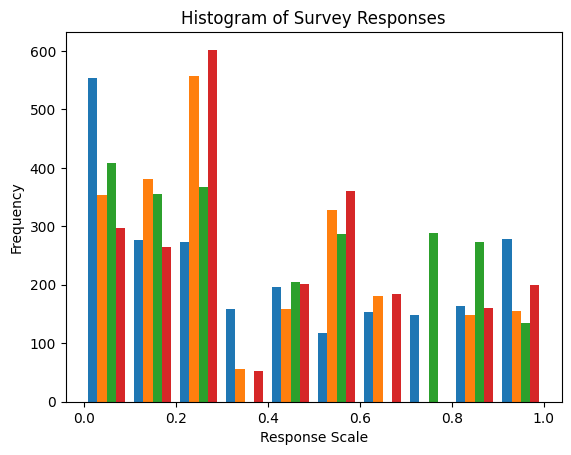

In [120]:
predictors = train_df[predictors]

plt.hist(predictors)
plt.title("Histogram of Survey Responses")
plt.xlabel("Response Scale")
plt.ylabel("Frequency")
plt.show()

## Manual Linear Regression

In [121]:
# See: https://ayoakin.medium.com/linear-regression-from-scratch-using-matrices-991df6e28f62

X = train_df[predictors].copy()
X["Going_outside:Social_event_attendance"] = train_df["Going_outside"] * train_df["Social_event_attendance"]
y = train_df[["Friends_circle_size"]].copy()

# Append column of 1s
X["Intercept"] = 1

# Transpose
X_T = X.T

# Calculate beta 1 using matrix form
B = np.linalg.inv(X_T @ X) @ (X_T @ y)

B.index = X.columns

# Compute predictions of y-hat using beta 1
predictions = X @ B

# Calculate Sum of Squares
SSR = ((y - predictions) ** 2).sum()
# Calculate Sum of Squares total
SST = ((y - y.mean()) ** 2).sum()
# Calculate R^2
R2 = 1 - (SSR / SST)

residuals = y - predictions

print("\nR-Squared: {}".format(R2.iloc[0]))
B, residuals.head()

ValueError: Boolean array expected for the condition, not float64

## Linear Regression using `statsmodels`

In [ ]:
standard_scaler = lambda col: col / max(col)
transformed_df = train_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Friends_circle_size",
]]

model = ols(
    formula='Friends_circle_size ~ Time_spent_Alone + Post_frequency + Going_outside + Social_event_attendance',
    data=transformed_df
).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     Friends_circle_size   R-squared:                       0.635
Model:                             OLS   Adj. R-squared:                  0.634
Method:                  Least Squares   F-statistic:                     1005.
Date:                 Sun, 13 Jul 2025   Prob (F-statistic):               0.00
Time:                         13:59:39   Log-Likelihood:                -5472.2
No. Observations:                 2320   AIC:                         1.095e+04
Df Residuals:                     2315   BIC:                         1.098e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   3.5178      0.235     14.973      0.000       3.057       3.979
Time_spent_Alone           -2.7947      0.279    -10.034      0.000      -3.341      -2.249
Post_frequency              2.1949      0.316      6.952      0.000       1.576       2.814
Going_outside               3.3598      0.296     11.364      0.000       2.780       3.940
Social_event_attendance     4.1512      0.311     13.349      0.000       3.541       4.761
==============================================================================
Omnibus:                       32.134   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.529
Skew:                           0.260   Prob(JB):                     1.42e-07
Kurtosis:                       2.762   Cond. No.                         9.57
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Scale Predictors as Proportions
Each predictor has a different survey scale range (0-5, 0-7, 0-11, etc), so we need to scale each as a proportion $\frac{x}{max(x)}$.

In [ ]:
test_df_scaled = test_df.copy()[[
    "Time_spent_Alone",
    "Post_frequency",
    "Going_outside",
    "Social_event_attendance",
    "Friends_circle_size",
    "Personality"
]]

# Combine scaled test data with predictions
test_df_scaled['Predicted'] = model.predict(test_df_scaled)

## (Optional) Switch Personality
We can switch the personality type of the observations to see the differences in the groups. Default setting will show data points from both introverts and extroverts. This is necessary as there are known outliers that may influence the inference of the model.

In [ ]:
class Personality(Enum):
    introvert = (0, "Introvert")
    extrovert = (1, "Extrovert")

def switch_personality(personality: Personality | None = None):
    if personality:
        return test_df_scaled[test_df_scaled["Personality"] == personality.value[0]]
    else:
        return test_df_scaled

test_df_scaled = switch_personality()

## Plot regression model

### Decision (Tree) Linear Regression
Plot each predictor against the predicted friend circle size and compare against the actual data points. Some calibration is needed.

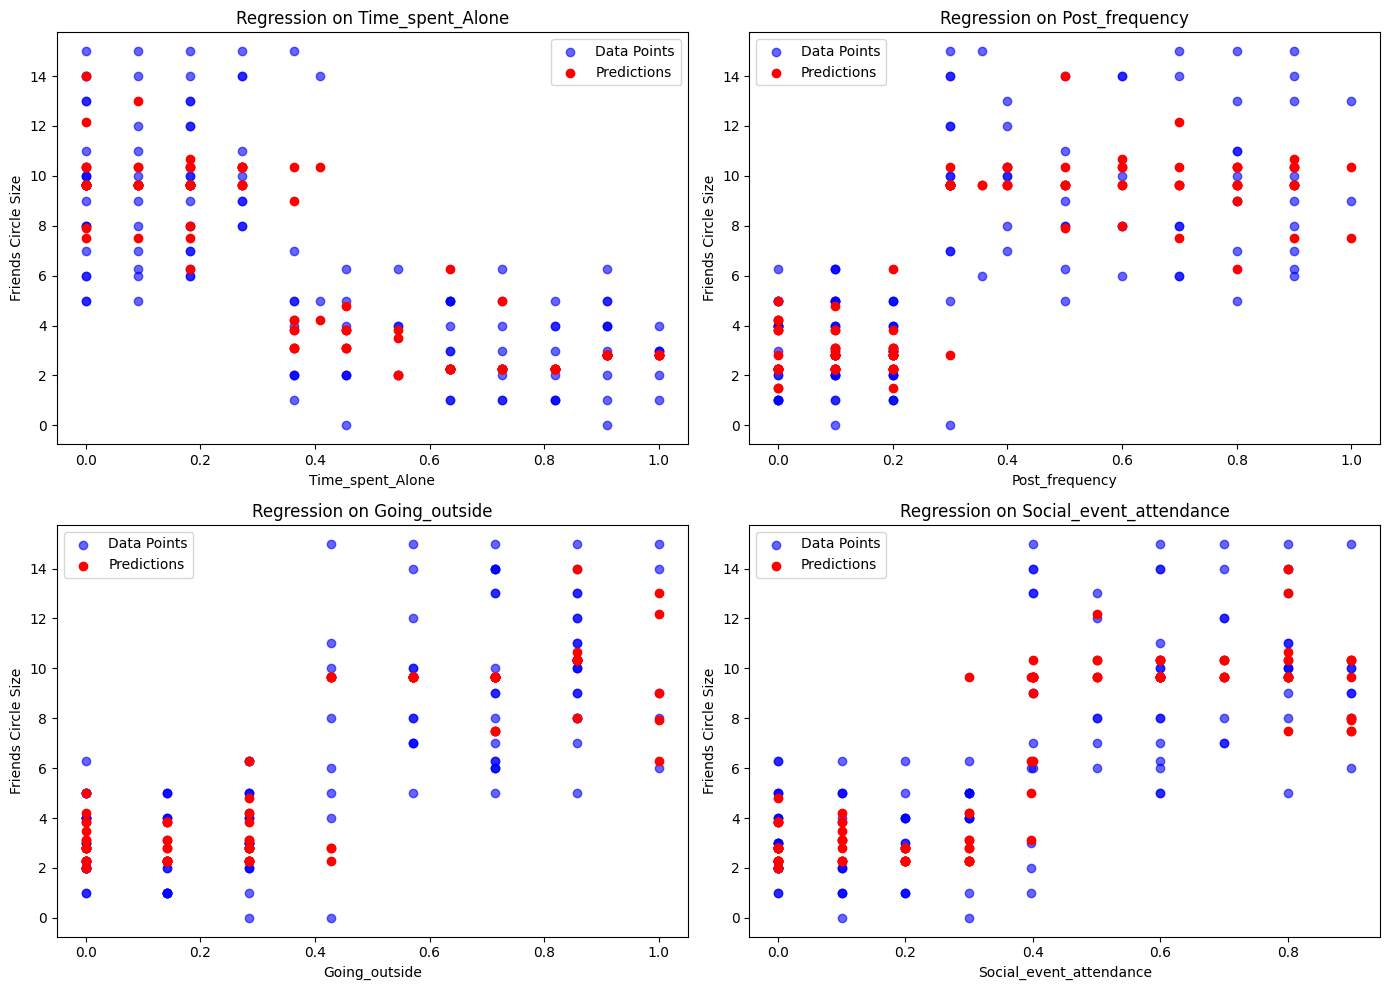

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, predictor in enumerate(predictors):
    ax = axs[i]
    X = test_df_scaled.drop('Friends_circle_size', axis=1)
    y = test_df_scaled['Friends_circle_size']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1863)

    # Create a DecisionTreeRegressor instance with maximum depth of 5
    dt_model = DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

    y_pred = dt_model.predict(X_test)

    ax.scatter(
        x=X_test[predictor],
        y=y_test,
        color="blue",
        alpha=0.6,
        label="Data Points"
    )
    ax.scatter(X_test[predictor], y_pred, color='red', label='Predictions')

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Friends Circle Size')
    ax.legend()
plt.tight_layout()
plt.show()

### OLS Linear Regression with CI and PI
Plot OLS linear regression for each predictor against friend circle size with confidence and predictor intervals.

**NOTE:** Because each predictor influences each other when plotting data points, a linear space of data between the min and max of each predictor was needed to be generated. Additionally, each of the other predictors need to be held constant. This means that this test data is synthetic, but is used for model visualization and is not integrated into the test and train samples.

                             OLS Regression Results                            
Dep. Variable:     Friends_circle_size   R-squared:                       0.635
Model:                             OLS   Adj. R-squared:                  0.634
Method:                  Least Squares   F-statistic:                     1005.
Date:                 Sun, 13 Jul 2025   Prob (F-statistic):               0.00
Time:                         13:55:25   Log-Likelihood:                -5472.2
No. Observations:                 2320   AIC:                         1.095e+04
Df Residuals:                     2315   BIC:                         1.098e+04
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept       

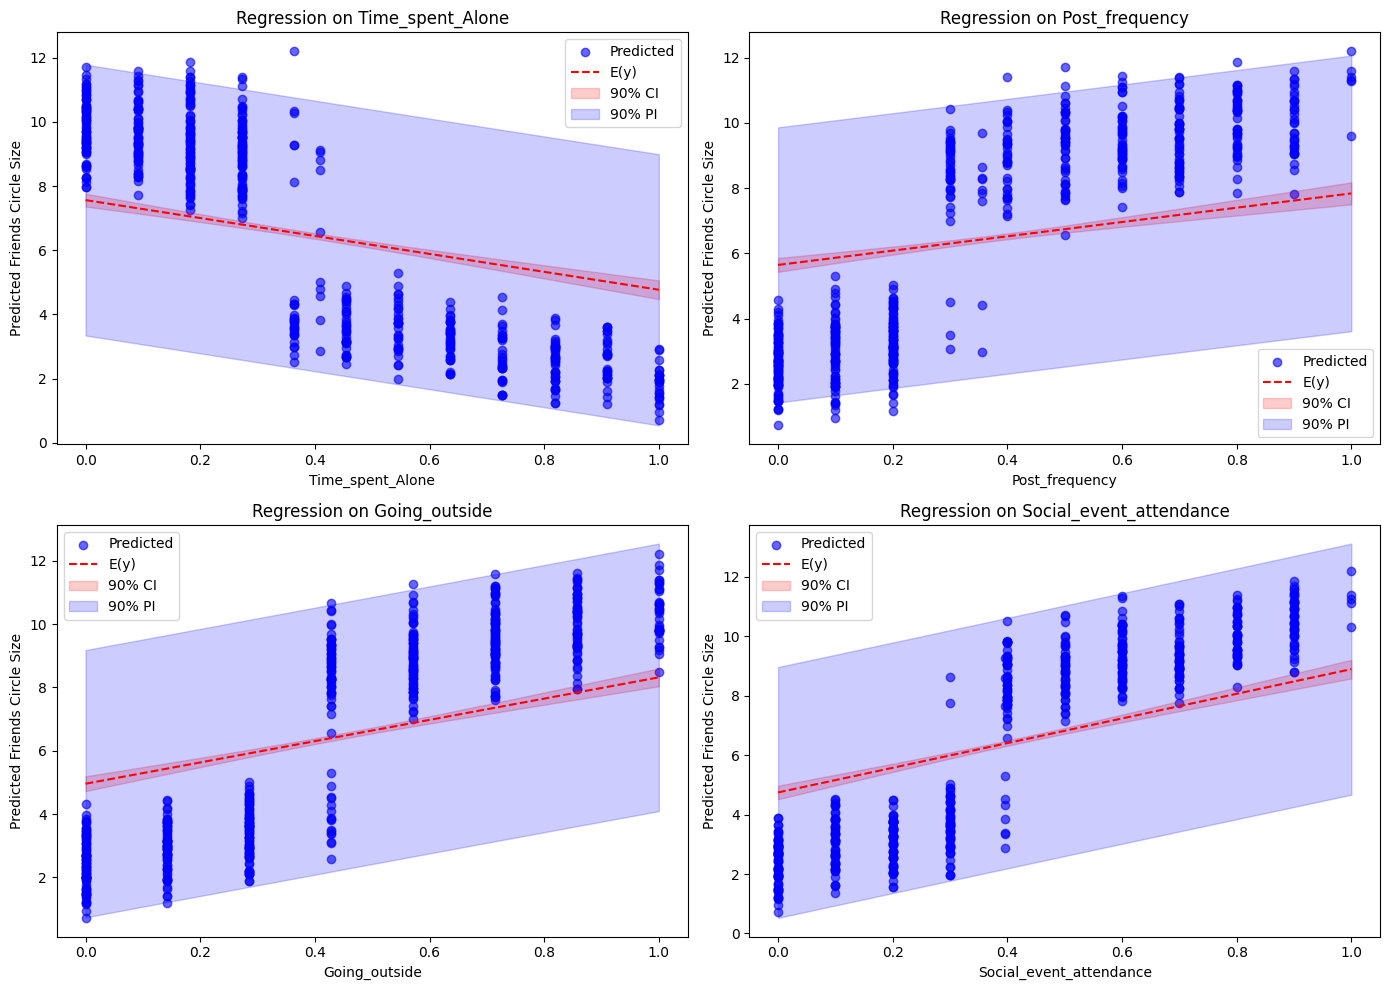

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

print(model.summary())

for i, predictor in enumerate(predictors):
    ax = axs[i]

    # Isolate effects of each predictor and hold other predictors constant (at mean).
    # Generate synthetic data within bounds of predictor; used for testing model
    x_vals = np.linspace(test_df_scaled[predictor].min(), test_df_scaled[predictor].max(), 100)

    # Create a DataFrame with mean values for other predictors
    fixed_data = pd.DataFrame({
        col: [test_df_scaled[col].mean()] * len(x_vals) if col != predictor else x_vals
        for col in predictors
    })
    # fixed_data = fixed_data[predictors]  # Ensure column order

    pred = model.get_prediction(fixed_data)
    pred_summary = pred.summary_frame(alpha=0.10)

    # Plot points
    ax.scatter(
        test_df_scaled[predictor],
        test_df_scaled["Predicted"],
        color="blue",
        alpha=0.6,
        label="Predicted"
    )

    # Regression Line
    ax.plot(
        x_vals,
        pred_summary['mean'],
        color='red',
        label='E(y)',
        linestyle='--'
    )

    # Confidence interval
    ax.fill_between(
        x_vals,
        pred_summary['mean_ci_lower'],
        pred_summary['mean_ci_upper'],
        color='red',
        alpha=0.2,
        label='90% CI'
    )

    # Prediction interval
    ax.fill_between(
        x_vals,
        pred_summary['obs_ci_lower'],
        pred_summary['obs_ci_upper'],
        color='blue',
        alpha=0.2,
        label='90% PI'
    )

    ax.set_title(f'Regression on {predictor}')
    ax.set_xlabel(predictor)
    ax.set_ylabel('Predicted Friends Circle Size')
    ax.legend()

plt.tight_layout()
plt.show()

### Determine Fitness of Residuals

Residual standard error: 2.558343353486672


/Users/prokope/KState/STAT-705/Project/.venv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


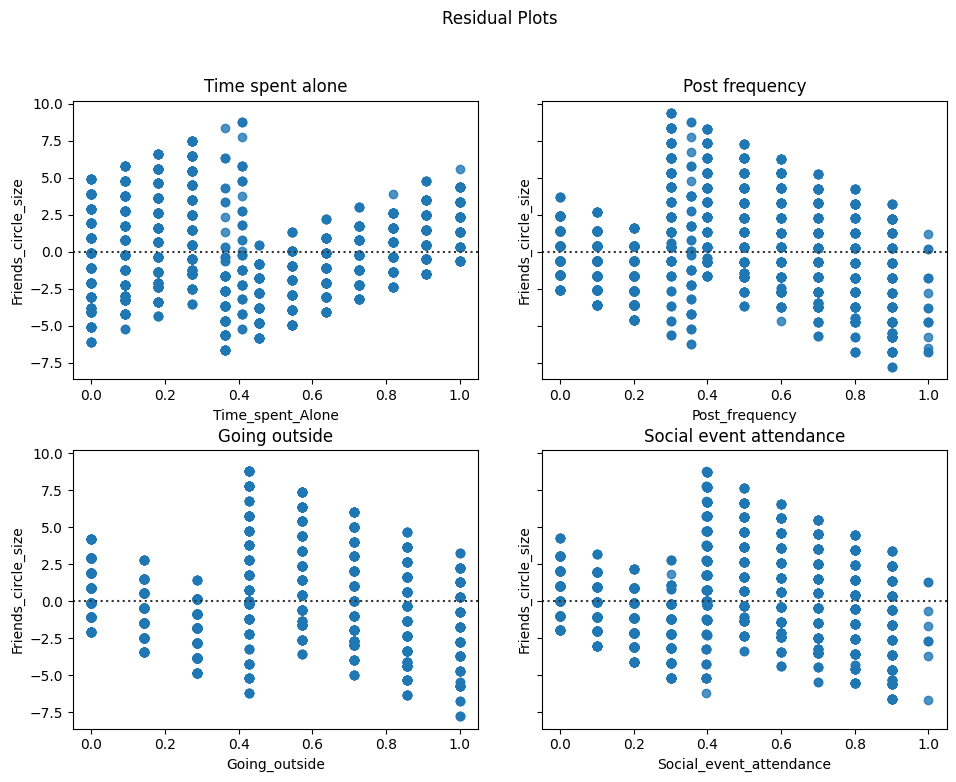

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
fig.suptitle("Residual Plots")
fig.tight_layout(pad=3.0)

plots_info = [
    {
        "name": "Time_spent_Alone",
        "title": "Time spent alone",
        "axes": (0, 0)
    },
    {
        "name": "Post_frequency",
        "title": "Post frequency",
        "axes": (0, 1)
    },
    {
        "name": "Going_outside",
        "title": "Going outside",
        "axes": (1, 0)
    },
    {
        "name": "Social_event_attendance",
        "title": "Social event attendance",
        "axes": (1, 1)
    }
]

print("Residual standard error: {}".format(np.std(residuals).iloc[0]))

for plot in plots_info:
    y_axis = plot["axes"][0]
    x_axis = plot["axes"][1]
    position = axes[y_axis, x_axis]
    sns.residplot(transformed_df, x=plot["name"], y="Friends_circle_size", ax=position)
    position.set_title(plot["title"])


## Prediction

In [127]:
B = model.params
print(B)

time_alone = B.iloc[1]
post_freq = B.iloc[2]
outside = B.iloc[3]
events = B.iloc[4]

# Regression variables were log transformed
y = time_alone*0.4 + post_freq*0.5 + + outside*0.5 + events*0.7
y

Intercept                  3.517847
Time_spent_Alone          -2.794725
Post_frequency             2.194925
Going_outside              3.359791
Social_event_attendance    4.151182
dtype: float64


np.float64(4.5652960305143075)